# Boundary vector score (BVS) - workflow and tests

Implementation of Debora's boundary vector score script in python

In [251]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [252]:
# Set up basics
import sys, os
import numpy as np 
from collections import OrderedDict
# Make plots pretty 
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='white')
%config InlineBackend.figure_format = 'retina'

import datajoint as dj

In [253]:
# Load base schema
schema = dj.schema(dj.config['dj_imaging.database'])
schema.spawn_missing_classes()

### Load an example ... 

In [254]:
current_session = "5a984faf5487dbfd"
session_key = Session.proj() & f'session_name = "{current_session}"'

cell_param_dict = OrderedDict([('ang_params_id', 'A'),
                             ('border_params_id', 'A'),
                             ('channel', 'primary'),
                             ('field_params_id', 'A'),
                             ('grid_params_id', 'A'),
                             ('map_params_id', 'A'),
                             ('noise_calc_id', 'A'),
                             ('s_t_params_id', 'A'),
                             ('shuffle_params_id', 'A'),
                             ('signal_type', 'spikes'),
                             ('spike_filter_id', 'A'),
                             ('trackingparams_id', 'A')])

In [255]:
some_ratemaps = Ratemap & session_key & cell_param_dict

In [256]:
cell =1 # 80
ratemap_entry = (some_ratemaps & f'cell_id = {cell}').fetch1()

In [257]:
rm      = np.ma.array(ratemap_entry['ratemap'], mask = ratemap_entry['mask_rm'])
rm_nans = np.ma.filled(rm, fill_value=np.nan).astype(np.float64)

In [258]:
rm_nans.shape

(32, 32)

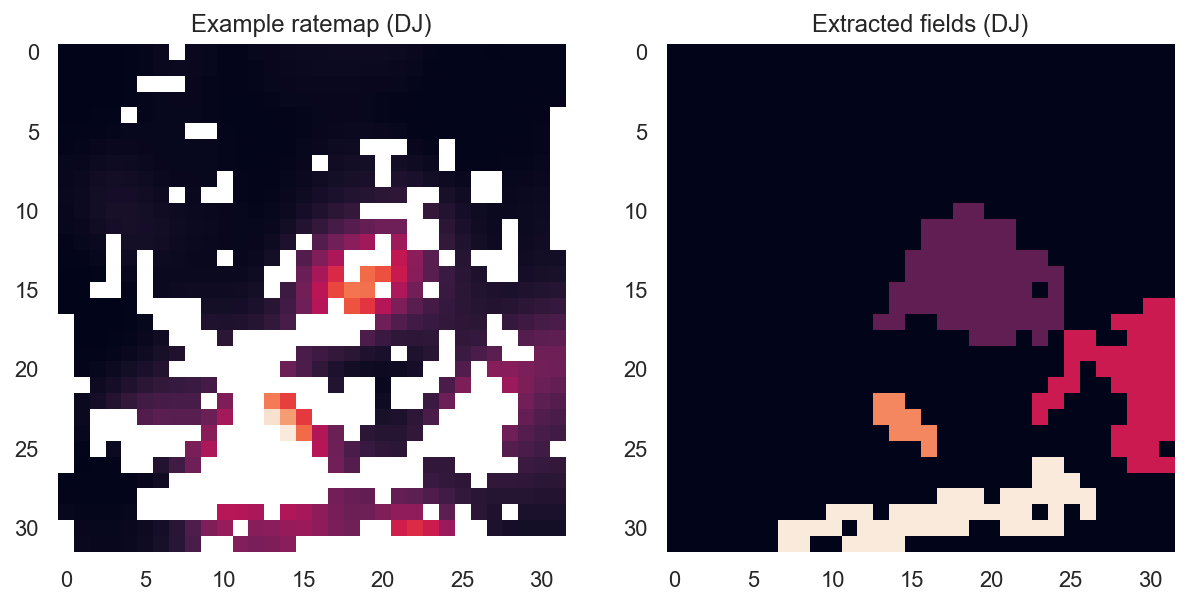

In [259]:
figure = plt.figure(figsize=(10,5))
ax = figure.add_subplot(121)
ax.imshow(rm_nans)
ax.set_title('Example ratemap (DJ)')
ax = figure.add_subplot(122)
ax.imshow(ratemap_entry['fields_map'])
ax.set_title('Extracted fields (DJ)')
sns.despine(left=True,bottom=True)

### Functions

In [260]:
from bvs.bv_score import calc_bv_score
from bvs.detect_fields import detect_fields

Thresholds
----------
fieldDetectionThresh: 183.99158755901578
fieldInclusionThresh: 330.0820985628956
minBin: 16

Fields
------
Detected 6 fields
Maxima of detected regions:   [ 727.017855    393.66850919  280.56405167  434.52544689 1024.68246461
  569.34619798]
Length of detected regions:   [42 34  3 15 14 38]
3 fields remain



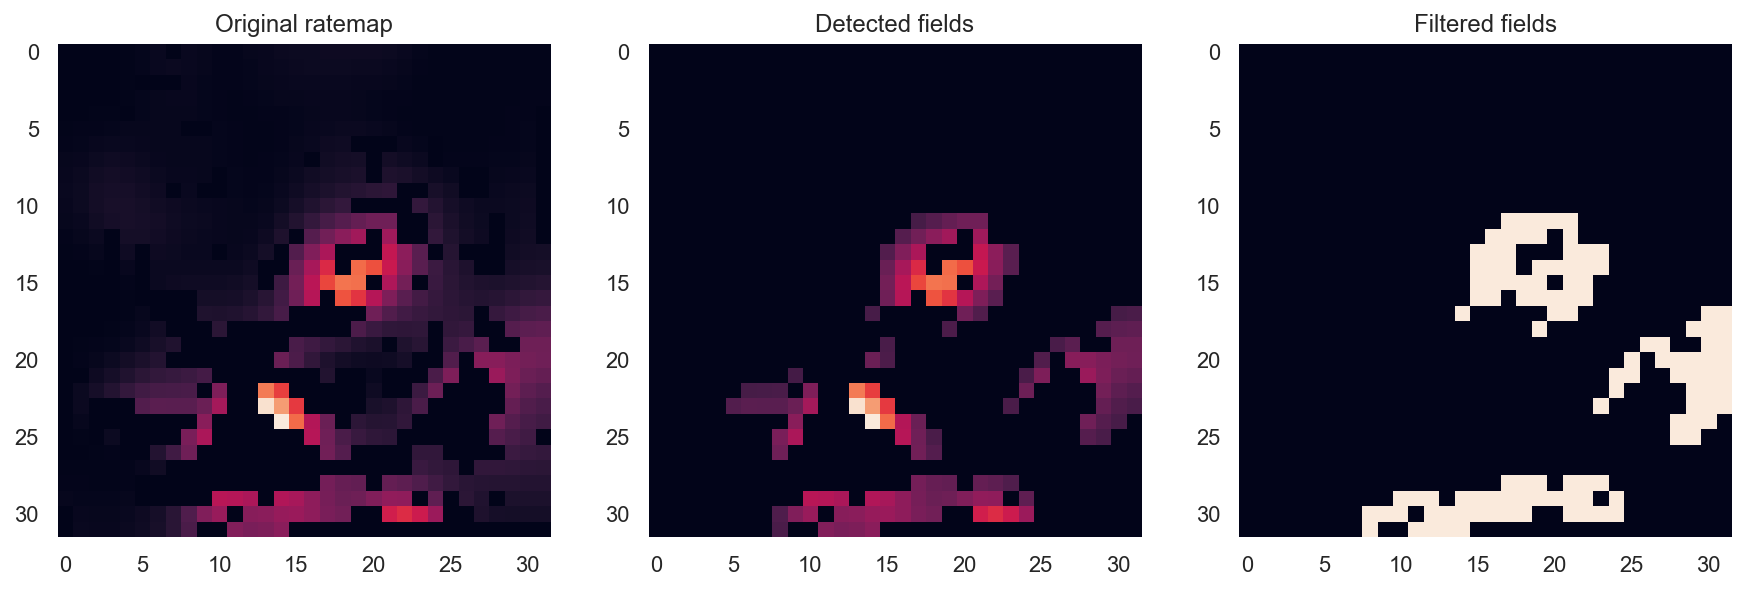

In [261]:
fieldmap, remaining_fields = detect_fields(rm_nans, minBin=16, show_plots=True, debug=True)

Barwidth ranges:  [1 2 3 4 5]
r value: 0.5
Looping over horizontal bars ... 
Score increased to -0.074 | yPos: 0 (barwidth: 1)
Score increased to  0.088 | yPos: 11 (barwidth: 1)
Score increased to  0.120 | yPos: 13 (barwidth: 1)
Score increased to  0.184 | yPos: 14 (barwidth: 1)
Score increased to  0.346 | yPos: 29 (barwidth: 1)
Score increased to  0.378 | yPos: 30 (barwidth: 1)

Looping over vertical bars ... 
Score increased to -0.074 | xPos: 0 (barwidth: 1)
Score increased to -0.009 | xPos: 8 (barwidth: 1)
Score increased to  0.023 | xPos: 12 (barwidth: 1)
Score increased to  0.055 | xPos: 14 (barwidth: 1)
Score increased to  0.120 | xPos: 15 (barwidth: 1)
Score increased to  0.152 | xPos: 16 (barwidth: 1)
Score increased to  0.184 | xPos: 17 (barwidth: 1)
Score increased to  0.249 | xPos: 21 (barwidth: 1)

Final boundary vector score: 0.3780241935483871 (horizontal)


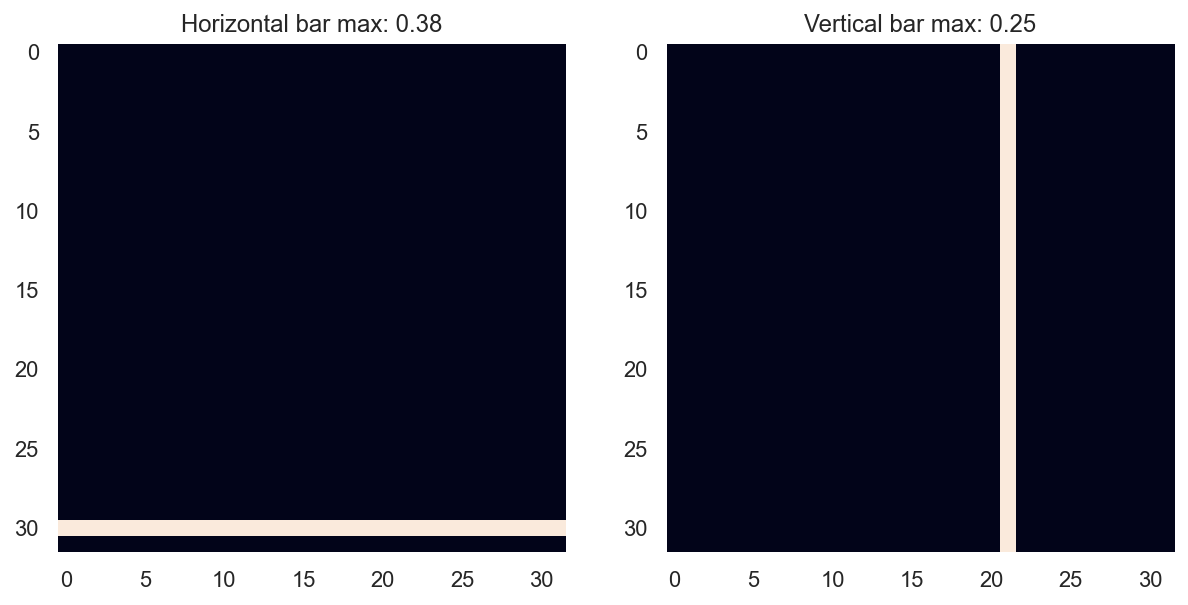

In [262]:
bvs, bvs_x, bvs_y, max_orientation = calc_bv_score(fieldmap, r=.5, barwidth_max=5, show_plots=True, debug=True)

In [263]:
bvs # max of x and y 

0.3780241935483871

### Save for matlab

In [264]:
from scipy.io import savemat

In [265]:
rm_dict = {'map': rm_nans, 
           'dj_session_name': current_session, 
           'dj_cell_id': cell, 
           'dj_cell_param_dict': cell_param_dict, 
           'xScore_python' : bvs_x['score_x'],
           'yScore_python' : bvs_y['score_y']}
savemat(f'matlab/test_data/cell_{cell}_{current_session}.mat',rm_dict)
print(f'Saved under \nmatlab/test_data/cell_{cell}_{current_session}.mat')

Saved under 
matlab/test_data/cell_1_5a984faf5487dbfd.mat


### Run bvs calculation over opexebo field map

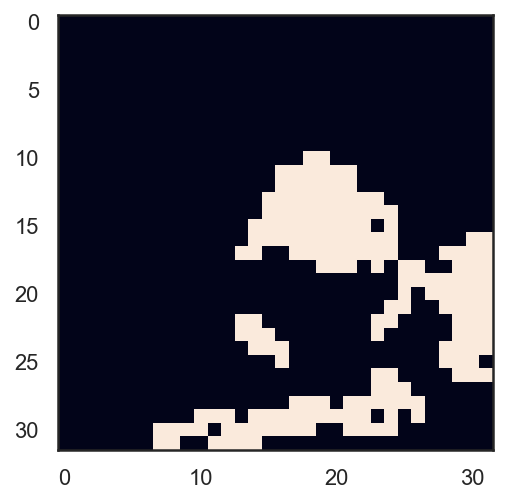

In [266]:
fieldmap_opex = ratemap_entry['fields_map'].copy()
fieldmap_opex[fieldmap_opex>0] = 1
plt.imshow(fieldmap_opex)

Barwidth ranges:  [1 2 3 4 5]
r value: 0.5
Looping over horizontal bars ... 
Score increased to -0.104 | yPos: 0 (barwidth: 1)
Score increased to -0.040 | yPos: 10 (barwidth: 1)
Score increased to  0.089 | yPos: 11 (barwidth: 1)
Score increased to  0.186 | yPos: 13 (barwidth: 1)
Score increased to  0.218 | yPos: 14 (barwidth: 1)
Score increased to  0.315 | yPos: 16 (barwidth: 1)
Score increased to  0.347 | yPos: 17 (barwidth: 1)
Score increased to  0.380 | yPos: 30 (barwidth: 1)

Looping over vertical bars ... 
Score increased to -0.104 | xPos: 0 (barwidth: 1)
Score increased to -0.040 | xPos: 7 (barwidth: 1)
Score increased to -0.008 | xPos: 12 (barwidth: 1)
Score increased to  0.057 | xPos: 13 (barwidth: 1)
Score increased to  0.186 | xPos: 14 (barwidth: 1)
Score increased to  0.218 | xPos: 16 (barwidth: 1)
Score increased to  0.251 | xPos: 18 (barwidth: 1)

Final boundary vector score: 0.3795362903225806 (horizontal)


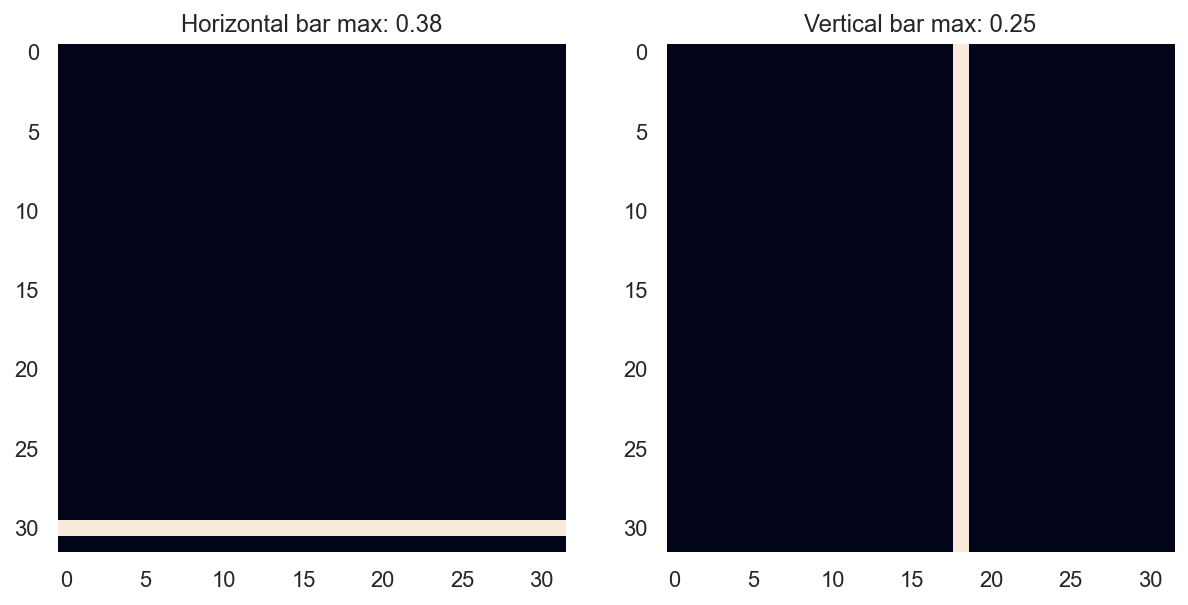

In [267]:
bvs, bvs_x, bvs_y, max_orientation = calc_bv_score(fieldmap_opex, r=.5, barwidth_max=5, show_plots=True, debug=True)

In [268]:
bvs_x

{'score_x': 0.3795362903225806,
 'bar_width': 1,
 'ypos': 30.5,
 'ypos_rel': 0.953125,
 'bar_map': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.]])}